# Ultra-High-Density Recording Probe Analyzer

- Analyze probe noise from saline recordings 
- Visualize impedance measurements and identify "bad" channels

## User Input

In [1]:
impfile = 'impedance_20200403-111349.h5' # Impedance File
basefile = 'experiment_C20200403-111923.h5' # Transferred saline baseline file
fs = 30000 # sample rate
columns = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], 
            [22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41], 
            [42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]] 
lowcut = 400 # Hz for bandpass filter
highcut = 5000 # Hz for bandpass filter
order = 6 # For bandpass filter 

- Assumes this python notebook, the data file, and the imp. file are in same dir
- `impfile` = the impedence h5 file for the probe in saline
- `basefile` = the short recording in saline to get baseline probe noise
- `fs` = sample rate
- `columns` = the probe map in array form (or list of lists). 
   - Each set (denoted by interior brackets) is a list of channels in that column
   - Left is closer to the tip of the shank (pointy end)
   - Ingrids probes have 3 rows, with 21,20, and 21 channels, respectively
   - The grid plotting routines take this into account
   - This variable may change from probe to probe
   - Make sure you check the `columns` variable against the probe map every time
- `lowcut` = lower limit of the bandpass filter
- `highcut` = upper limit of the bandpass filter
- `order` = order of the filtering function. >3 is in the flat part of the curve. 5 and 6 are in the middle.

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd

## Read in impedence data

In [3]:
f_imp = h5py.File(impfile, 'r') # Read in the impedance file
x_lim = [0,256]    # Change x-axis manually [start, end]
y_lim = [0,7500]   # Change y-axis manually [low, high]

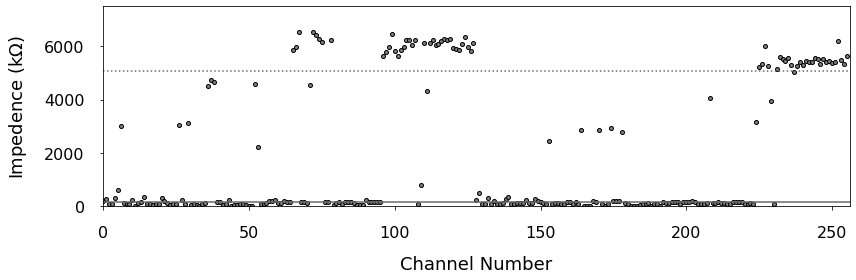

In [4]:
def get_impedance(f_imp):
    fig, ax = plt.subplots(figsize = (12,4))
    imp = f_imp['impedanceMeasurements'][:]
    x = np.where (imp > 0)[0]
    y = [imp[i] / 1000 for i in x] # kOhms
    ax.plot(x, y, ls = 'none', markersize = 4, marker = 'o', color = 'gray', mec = 'black')  
    ax.set_ylabel ('Impedence (k' + r'$\Omega$' + ')', fontsize = 18, labelpad = 15)
    ax.set_xlabel ('Channel Number', fontsize = 18, labelpad = 15)
    plt.tick_params(axis = 'both', which = 'major', pad = 15, labelsize = 16)
    med = np.median(y)
    rng = np.ptp(y)
    high = np.where(y > np.median(y) + rng * 0.75)[0]
    low = np.where (y < np.median(y)- rng * 0.75)[0]
    adj_y = [y1 for y1 in y if y1 not in low]
    adj_y = [y1 for y1 in y if y1 not in high]
    adj_high = np.where(y > np.median(adj_y) + rng * 0.75)[0]
    adj_low = np.where (y < np.median(adj_y) - rng * 0.75)[0]
    ax.set_xlim(x_lim[0],x_lim[1])
    ax.set_ylim(y_lim[0],y_lim[1])
    report = {'avg': np.median(adj_y),
          'std': rng,
          'high': adj_high,
          'low' : adj_low}    
    
    display(HTML("<hr><h4>Median impedence = " + str(round(report['avg'],3)) + 
                 "<br> Range =  " + str(round(report['std'],3)) 
                 + '<br>' 
                 + "Channels with High Resistance (greater than 75% of median) =  "  
                 + str(report['high']).replace('[','').replace(']', '') + "<br>" +
                 "Channels with Low Resistance (less than 75% of median) = <br>" +
                str(report['low']).replace('[','').replace(']', '') +  "<hr color = 'gray'><br>"))
    
    ax.axhline(report['avg'], color = 'dimgray')
    ax.axhline(med + rng * 0.75, ls = ":", color = 'dimgray')
    ax.axhline(med - rng * 0.75, ls = ":", color = 'dimgray')

    plt.tight_layout()
    plt.savefig(impfile.replace('.h5', '_impedance.png'))
    
    return report, x, y
    
imp_report, channels, imp = get_impedance (f_imp)


## Read in the baseline probe data (saline recordings)
- for a 5 minute file it takes 10-30 mins
- keep checking for "dead kernel" errors
 - no dead kernel, it's still working

In [5]:
columns = np.array(columns) # convert to numpy array for speed
f_base = h5py.File(basefile, 'r') # Read in the probe noise file
x_subs = f_base.get('sample_index') # channel # (x)
subs = f_base.get('channel_data') # Get baseline y for all channels
subs = subs[:, channels] * 0.195 # Remove unconnected channels and scale the data to microvolts
display (HTML("<hr><h4>Data consists of " + str(subs.shape[1]) + 
              " columns of data (channels, x) and " + str(subs.shape[0]) 
              + " rows of data (measurements, y). Recording is " + 
              str(round(len(x_subs)/(fs * 60),2)) + " mins long. <hr>"))

## Get noise levels for unfiltered  probe data
- This will allow us to set thresholds for detecting neuronal activity vs background noise

In [6]:
window = [0, 30000] # Default window is the first second in the recording

In [7]:
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(subs[window[0]:window[1], chan]))
    medians.append(np.median(subs[window[0]:window[1], chan]))
    sds.append(np.std(subs[window[0]:window[1], chan]))
    rngs.append(np.ptp(subs[window[0]:window[1], chan]))

unfiltered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(unfiltered_stats.head().to_html()))

,means,medians,sds,rngs
0,6389.567015,6389.565,6.405504,52.260
1,6389.566157,6390.150,7.053797,55.965
2,6389.618963,6389.760,4.282394,31.785
3,6389.385997,6389.370,4.158433,32.955
4,6389.338033,6389.565,7.376130,61.815


## Bandpass Filter (butterworth) of baseline probe data
- Have to analyze a subset of channels at a time or you get dead kernels 
- If recordings are very long, you can break it down into 64 channels at a time by changing subs[:, chan] to subs[0:64, chan] for the first 64 channels.uyoSimilarly, it could be subs[64:128, chan] or whatever length you need.

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=order):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=order):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

def get_filtered (channels, df):
    display (HTML("<h4>Analyzing channel: "))
    for chan in channels:
        print(chan, end = ' ')
        order = 6
        x = np.arange(len(subs[:,chan]))
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = sosfreqz(sos, worN=2000)
        df[chan] = butter_bandpass_filter(subs[:,chan], lowcut, highcut, fs, order=order)
    return df

filtered = pd.DataFrame()
filtered = get_filtered(channels, filtered)   


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 

## Get noise level of filtered probe data

In [9]:
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(filtered[chan]))
    medians.append(np.median(filtered[chan]))
    sds.append(np.std(filtered[chan]))
    rngs.append(np.ptp(filtered[chan]))

filtered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(filtered_stats.head().to_html()))


,means,medians,sds,rngs
0,0.000042,0.005555,3.811244,38.361210
1,0.000044,-0.005340,3.609221,33.168638
2,0.000061,-0.000759,2.430833,36.805415
3,-0.000021,-0.002775,2.409816,31.250013
4,-0.000015,-0.001353,4.404856,39.872119


## Save the filtered probe data with stats

In [10]:
hf_probe = h5py.File(basefile.replace('.h5', '_probe.h5'), 'w')
hf_probe.create_dataset('sample_index', data = filtered.iloc[:,0])
hf_probe.create_dataset('unfiltered_y', data = subs[:,channels])
hf_probe.create_dataset('channel_data', data = filtered.loc[:,channels])
hf_probe.create_dataset('unfiltered_stats', data = unfiltered_stats)
hf_probe.create_dataset('filtered_stats', data = filtered_stats)
hf_probe.close()

## Plot unfiltered probe data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

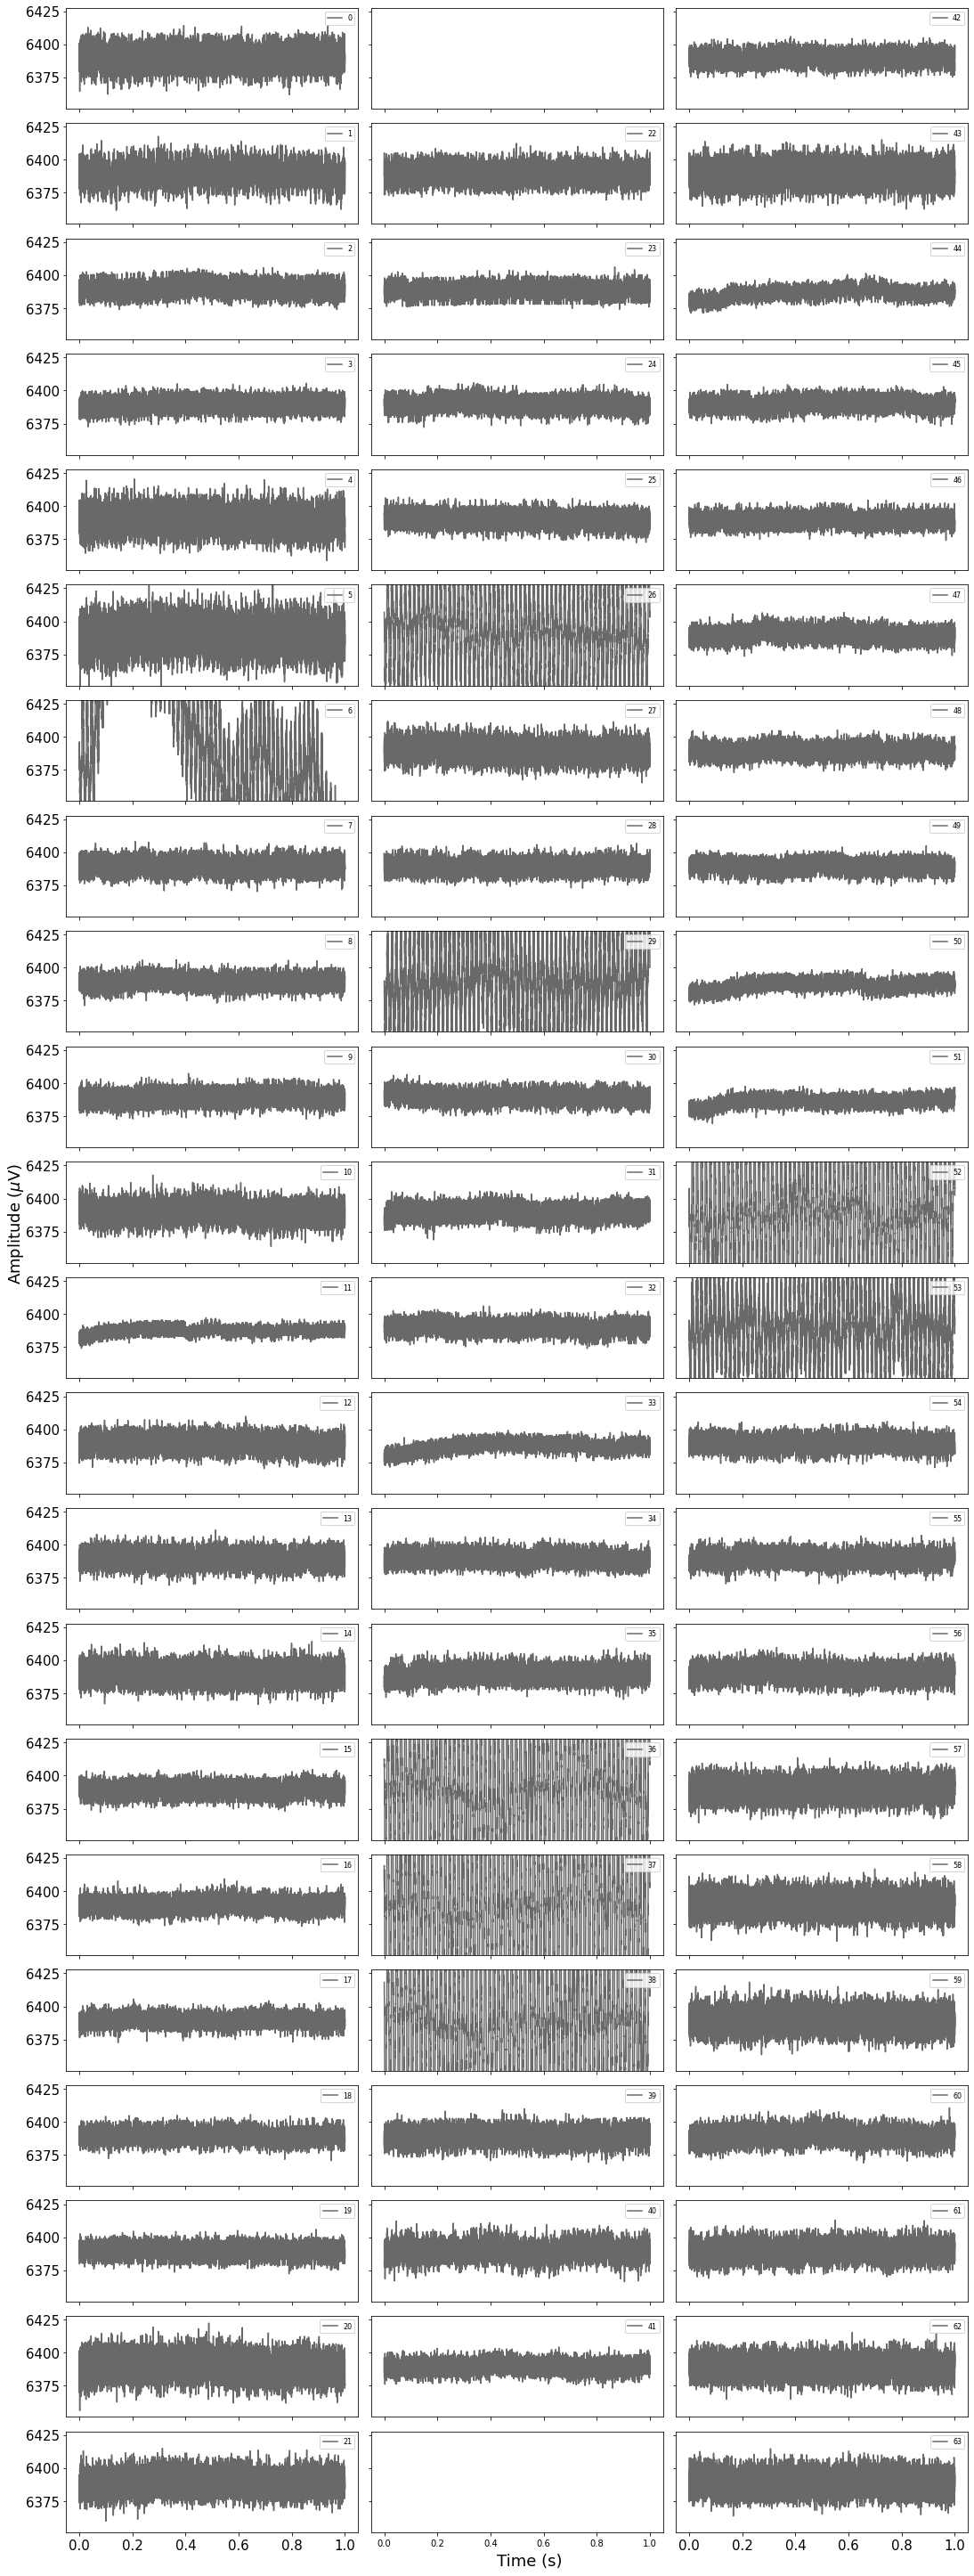

In [11]:
def grid_plot_unfiltered(columns, xs, ys):
    start = window[0]
    end = window[1]
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (len(columns[0]),int(columns.shape[0]), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    for j in np.arange (0,columns.shape[0]):
        for i,col in enumerate(columns[j]): 
            if j == 1: # Offset for middle row (grid is 66 panels, but we only have 64 channels. Middle row is shorter) 
                i = i + 1
            print(col, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, subs[start:end,col], color = 'dimgray', 
                            label=str(col)) # Unfiltered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            y_lims = ax[i][j].get_ylim()
            ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(unfiltered_stats.means[col] - unfiltered_stats.rngs[col]*0.75, 
                              unfiltered_stats.means[col] + unfiltered_stats.rngs[col]*0.75)
            ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (s)', va='center',  fontsize = 18)
    plt.savefig (basefile.replace('.h5','_unfiltered.png'))
    display(HTML('<hr>'))


grid_plot_unfiltered(columns, x_subs, subs)

## Plot filtered probe data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

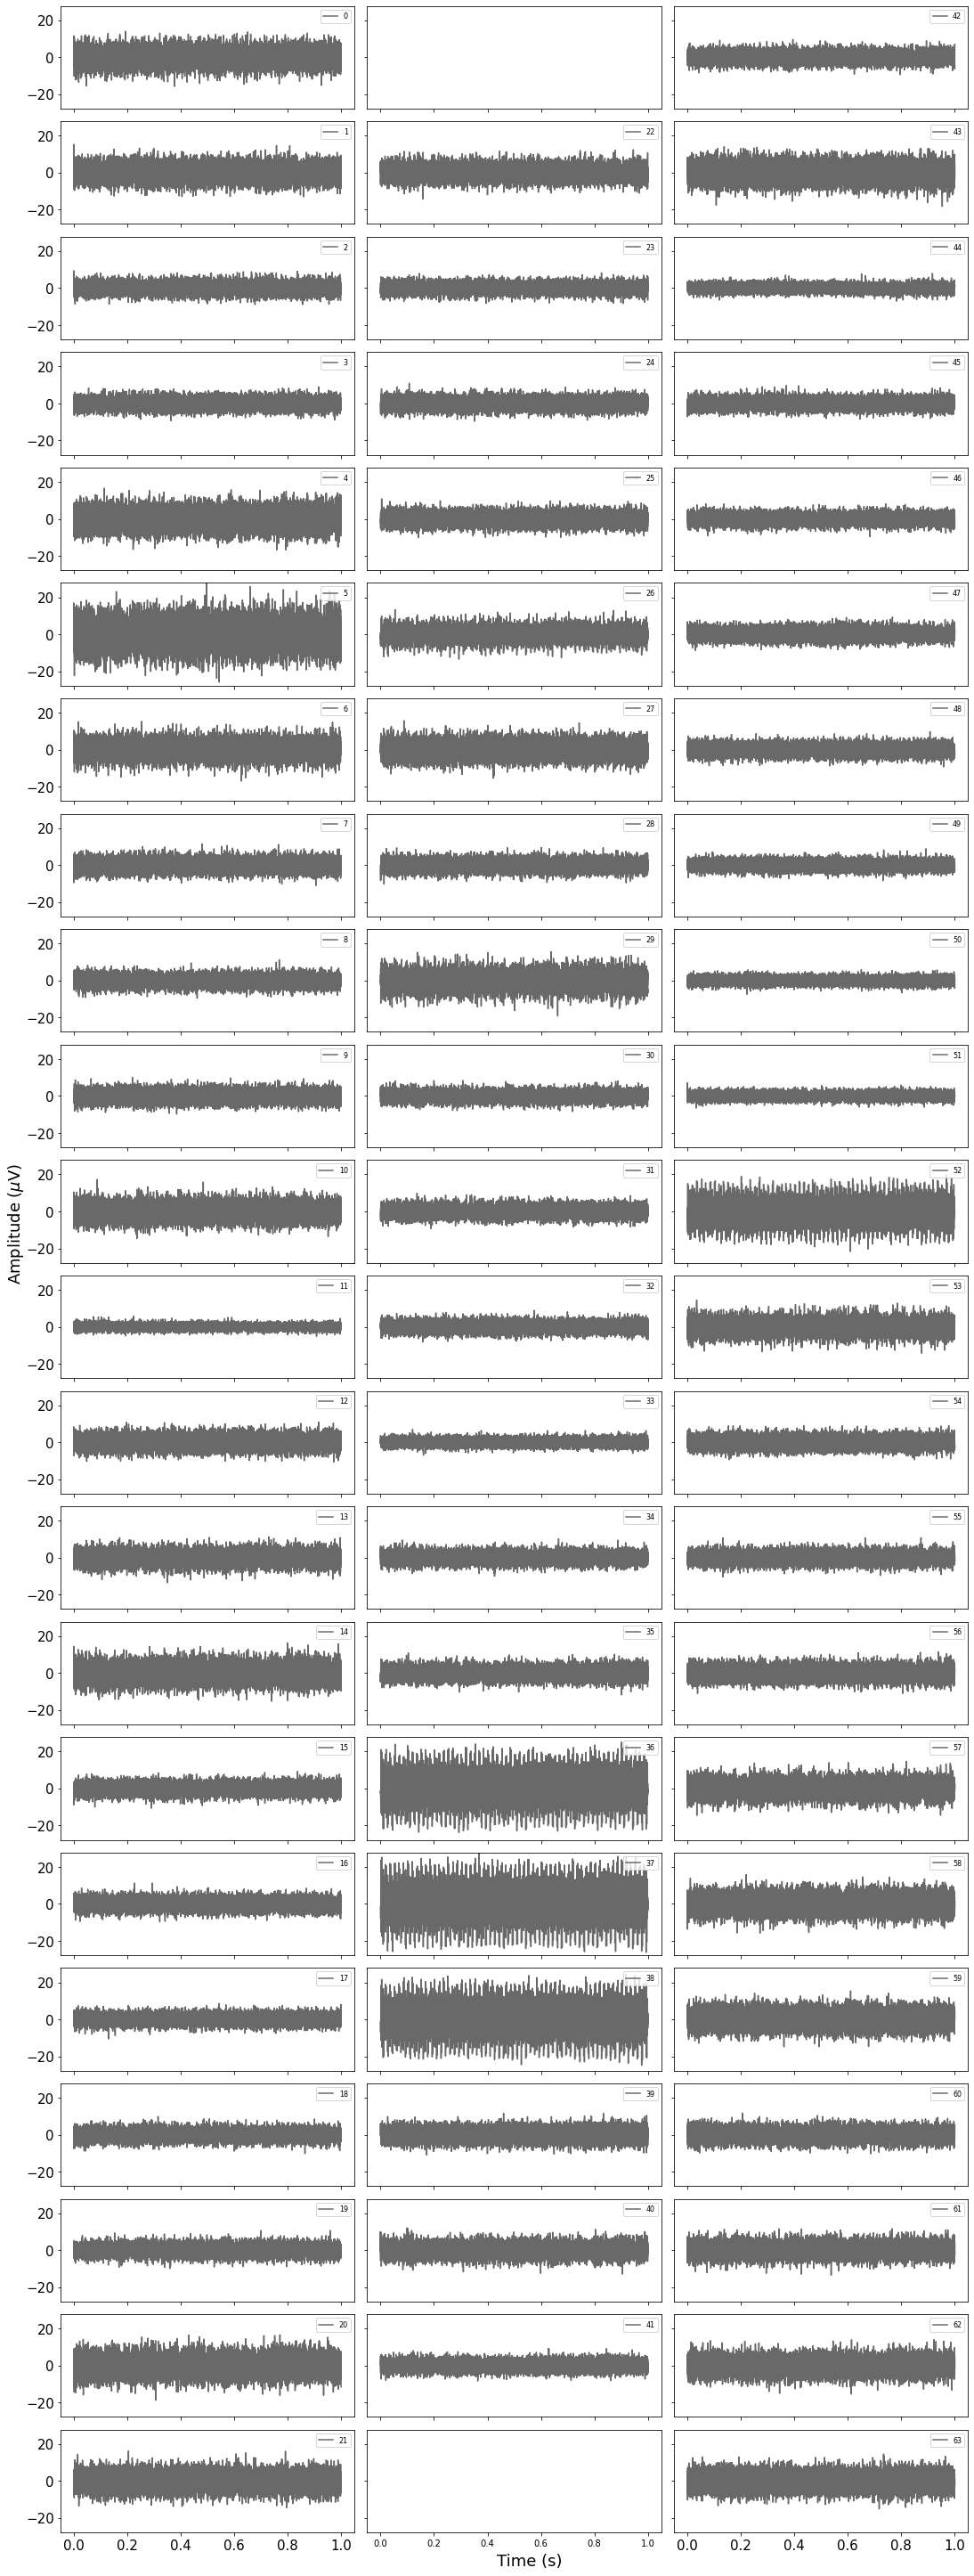

In [12]:
def grid_plot_filtered(columns, xs, ys):
    start = window[0]
    end = window[1]
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (len(columns[0]),int(columns.shape[0]), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    for j in np.arange (0,columns.shape[0]):
        for i,col in enumerate(columns[j]): 
            if j == 1: # Offset for middle row (grid is 66 panels, but we only have 64 channels. Middle row is shorter) 
                i = i + 1
            print(col, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, filtered.iloc[start:end,col], color = 'dimgray', 
                            label=str(col)) # Unfiltered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            y_lims = ax[i][j].get_ylim()
            ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(filtered_stats.means[col] - filtered_stats.rngs[col]*0.75, 
                              filtered_stats.means[col] + filtered_stats.rngs[col]*0.75)
            ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (s)', va='center',  fontsize = 18)
    plt.savefig (basefile.replace('.h5','_filtered.png'))
    display(HTML('<hr>'))


grid_plot_filtered(columns, x_subs, filtered)